<a href="https://colab.research.google.com/github/kienprojects/Machine-Learning-course/blob/main/NaiveBayes_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NaiveBayes Homework - Answer**

Aug 20, 2024

---



## **1. Bài toán**

Cho tập dữ liệu về bệnh ung thư: https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

Trong đó là các thông tin về đặc điểm của tế bào đã được ghi nhận thành các thuộc tính (radius_mean, texture_mean, ...), thể hiện dưới dạng bảng. Cùng với đó là các chẩn đoán (diagnosis) liệu tế bào đó có phải là tế bào ung thư hay không.

Hãy xây dựng mô hình Naive Bayes để dự đoán liệu một tế bào với các đặc điểm cho trước có phải là một tế bào ung thư hay không?

## **2. Import các thư viện cần thiết và load dữ liệu từ file**

In [13]:
# Import các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/VINBIGDATA/MachineLearning/00_Assignment/05_Naive_Bayes

/content/drive/.shortcut-targets-by-id/1TvCG3X3dcbtWR5iQlJl5HnUNGb5lsmIA/00_Assignment/05_Naive_Bayes


In [4]:
# Load data
data = pd.read_csv("cancer_data.csv")
data.head()  # Quan sát dữ liệu cho thấy, tập dữ liệu đã được xử lí khá "sạch"

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [6]:
# Loại trường không cần thiết: id, unnamed
data = data.drop(["id", "Unnamed: 32"], axis=1)

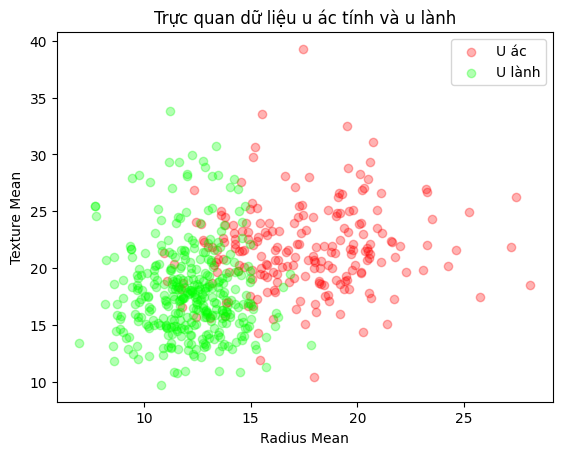

In [7]:
# Trực quan hóa về dữ liệu: u ác tính và u lành:
M = data[data.diagnosis == "M"]  # dữ liệu ứng với u ác tính
B = data[data.diagnosis == "B"]  # dữ liệu ứng với u lành

plt.title("Trực quan dữ liệu u ác tính và u lành")
plt.xlabel("Radius Mean")
plt.ylabel("Texture Mean")
plt.scatter(M.radius_mean, M.texture_mean, color="red", label="U ác", alpha=0.3)
plt.scatter(B.radius_mean, B.texture_mean, color="lime", label="U lành", alpha=0.3)
plt.legend()
plt.show()

## **Tiền xử lí trước khi huấn luyện mô hình:**

In [8]:
# Câu hỏi: Đưa trường chẩn đoán từ dạng chữ thành dạng số
# Code ###########
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})
#####################################################

In [9]:
# Câu hỏi: Tách thuộc tính và nhãn:

# Code ###############
X = data.drop('diagnosis', axis=1)
y = data['diagnosis']

#################

In [10]:
# Chuẩn hóa các trường của X
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X)

StandardScaler()

In [11]:
# Câu hỏi: Chia dữ liệu train/test:
from sklearn.model_selection import train_test_split

# Code ###################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
##############################

## **Xây dựng và đánh giá mô hình Naive Bayes:**

In [14]:
# Câu hỏi: Multinormial NB:

# Code ###################################
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred_mnb = mnb.predict(X_test)
print("Multinomial NB accuracy:", accuracy_score(y_test, y_pred_mnb))
##########################################

Multinomial NB accuracy: 0.9385964912280702


In [23]:
# Câu hỏi: Gaussian NB:

# Code ########################################
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)
print("Gaussian NB accuracy:", accuracy_score(y_test, y_pred_gnb))

#############################################

Gaussian NB accuracy: 0.9736842105263158


In [24]:
sample = X_test.iloc[0].values.reshape(1, -1)
print("GNB prediction:", gnb.predict(sample))

GNB prediction: [0]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


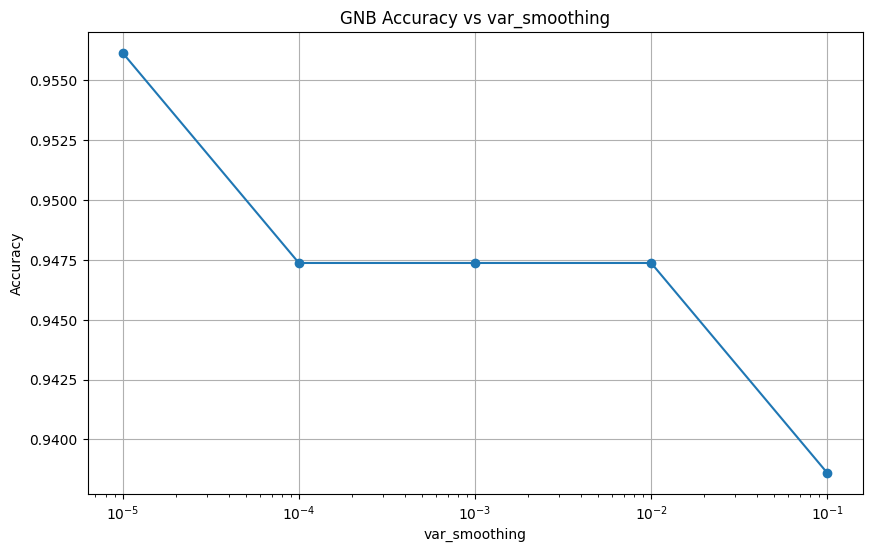

0.1 0.9385964912280702
0.01 0.9473684210526315
0.001 0.9473684210526315
0.0001 0.9473684210526315
1e-05 0.956140350877193


In [26]:
# Quan sát độ chính xác trên tập test của GNB khi thay đổi tham số var_smoothing
import matplotlib.pyplot as plt
from sklearn import naive_bayes
from sklearn.metrics import accuracy_score
var_smoothings = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
accs = []

for var_smoothing in var_smoothings:
    model_GNB = naive_bayes.GaussianNB(var_smoothing=var_smoothing)
    model_GNB.fit(X_train, y_train)

    y_pred = model_GNB.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accs.append(acc)

# Vẽ đồ thị
plt.figure(figsize=(10, 6))
plt.semilogx(var_smoothings, accs, marker='o')
plt.xlabel('var_smoothing')
plt.ylabel('Accuracy')
plt.title('GNB Accuracy vs var_smoothing')
plt.grid(True)
plt.show()

for i in range(len(accs)):
    print(var_smoothings[i], accs[i])
